# Recurrent learning

In this file the network is working with a feedback, online learning is used to make a correction when it might exagerates. 

In [7]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime
dpath = 'dataset/preprocessed/'

#Makes the time a continuous value to work with ESN.
def time_linearisation(date): 
    format_code = "%Y%m%d"
    dt = datetime.strptime(date, format_code)

    # Week day
    dow = dt.weekday()
    dow_sin = math.sin(2 * math.pi * dow / 7)
    dow_cos = math.cos(2 * math.pi * dow / 7)

    # Month day
    dom = dt.day - 1
    days_in_month = 31  # number of days in a month approximation
    dom_sin = math.sin(2 * math.pi * dom / days_in_month)
    dom_cos = math.cos(2 * math.pi * dom / days_in_month)

    # Day of Year
    doy = dt.timetuple().tm_yday - 1
    days_in_year = 365.25  # number of days in a year approximation
    doy_sin = math.sin(2 * math.pi * doy / days_in_year)
    doy_cos = math.cos(2 * math.pi * doy / days_in_year)

    # Months
    month = dt.month - 1
    month_sin = math.sin(2 * math.pi * month / 12)
    month_cos = math.cos(2 * math.pi * month / 12)

    return np.array([
        doy_sin, doy_cos,
    ])

print(time_linearisation("20230630"))  # Example usage


[ 0.04514102 -0.99898062]


Same as in the previous file, gathering data. 

In [ ]:
# obj=[]
# #Notes Function building the data useful for the training. 
# def gathering_data(csv_reader,current_size, ind ):
#     here = 0   
#     if current_size>1500:
#         for row in csv_reader:
#             if not row or row[0].startswith("R") or here%6!=0:
#                 continue
#             data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
#             data[here + ind ,8]= float(row[2])
#             data[here + ind ,9] = float(row[3])
#             here+=1
#     else :
#         for row in csv_reader:
#             if not row or row[0].startswith("R"):
#                 continue
#             data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
#             data[here + ind ,8]= float(row[2])
#             data[here + ind ,9] = float(row[3])
#             here+=1
#     return data

# def size(repo):
#     lst = os.listdir("./archive/")
#     lst.sort()
#     list = []
#     # sorting to get data in the chronologic time. 
#     for file in lst : 
#         size = 0 
#         with open(dpath + file, mode = 'r') as file :
#             csv_reader = csv.reader(file)
#             for row in csv_reader:
#                 if not row or row[0].startswith("R"):
#                     continue
#                 size +=1
#             list.append(size)
#     return list



# def correcting_size(repo): 
#     lst = os.listdir("./archive/")
#     lst.sort()
#     current= 0 
#     new_list =[]
#      # sorting to get data in the chronologic time. 
#     for file in lst : 
#         here =0
#         size = 0 
#         if list[current]<1500:
#             new_list.append(list[current])
#             current +=1
#             continue 
#         else : 
#             with open(dpath + file, mode = 'r') as file :
#                 csv_reader = csv.reader(file)
#                 for row in csv_reader:
#                     if not row or row[0].startswith("R") or here%6!=0:
#                         here +=1
#                         continue
#                     else:
#                         here+=1
#                         size  +=1
#                 new_list.append(size)
#                 current+=1
#     return new_list
# #Doing it with each file 
# list = size(dpath)
# final_list = correcting_size(dpath)
# data = np.zeros((sum(final_list),10))

# def gathering_all(repo):
#     lst = os.listdir("./archive/")
#     lst.sort()
#     current = 0
#     ind = 0 
#     # sorting to get data in the chronologic time. 
#     for file in lst : 
#         with open(dpath + file, mode = 'r') as file :
#             csv_reader = csv.reader(file)
#             current_size = list[current]
#             gathering_data(csv_reader, current_size, ind)
#         ind += final_list[current]
#         current +=1

# gathering_all(dpath)

In [ ]:
# Load preprocessed data

def load_X_Y(filepath):
    X = []
    inputs_columns = { 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20}
    with open(filepath, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if not row or row[0].startswith("D"):
                continue
            time_features = time_linearisation(row[0])
            X.append(np.concatenate([time_features] + [[float(row[i])] for i in inputs_columns]))
        return np.array(X)
    
data = load_X_Y(dpath + 'A146020302.csv')


array([[ 9.54066550e-01, -2.99594756e-01, -9.90000000e+01, ...,
         2.43980000e+03,  7.72000000e-01,  1.03000000e+00],
       [ 7.18791877e-01, -6.95225314e-01, -9.90000000e+01, ...,
         2.72410000e+03,  7.32000000e-01,  1.00900000e+00],
       [ 7.94772999e-02, -9.96836676e-01, -9.90000000e+01, ...,
         2.89430000e+03,  6.31000000e-01,  8.64000000e-01],
       ...,
       [-4.38306723e-01, -8.98825465e-01,  2.55000000e+02, ...,
         2.77220000e+03,  2.68000000e-01,  2.63000000e-01],
       [-4.53703086e-01, -8.91152910e-01,  2.62000000e+02, ...,
         2.91960000e+03,  2.67000000e-01,  2.58000000e-01],
       [-4.68965191e-01, -8.83216649e-01,  2.76000000e+02, ...,
         3.01560000e+03,  2.59000000e-01,  2.52000000e-01]],
      shape=(10657, 14))

In [16]:
import matplotlib.pyplot as plt 
def plot_results(y_pred, y_test, sample=400):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

Building the network, yet as we saw in the previous file, an ESN with a ridge can not forecast subtilities of the data. This time, an RLS will be used. This time, the forecast will be 48 corresponding to 24h according to the dataset. It should be a good approximation for an electricty producer. 

In [20]:
from reservoirpy.datasets import to_forecasting
data = load_X_Y(dpath + 'A146020302.csv')
x,y= to_forecasting(data, forecast=1)
print(x.shape, y.shape)
y = y[:, 8].reshape(-1, 1) # chosing the data that will be used (electricity consuption)
units = 100 
leak_rate = 0.1
spectral_radius = 0.7
input_scaling = 1.
connectivity = 0.8
input_connectivity = 0.2
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:400], y[:400]
X_test1, y_test1 = x[400:], y[400:]
X_test1 = np.asarray(X_test1) # chosing the data that will be used (electricity consuption)
X_test1 = X_test1.reshape(X_test1.shape[0], -1) # reshaping data that they could be used by reservoir py
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


(10656, 14) (10656, 14)


In [21]:
from reservoirpy.nodes import RLS
from reservoirpy.nodes import Reservoir 
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = RLS(1)


esn_online = reservoir >> readout

In [22]:
readout = RLS(1)
outputs_pre = np.zeros((len(X_train1), 1))

for t, (x_t, y_t) in enumerate(zip(X_train1, y_train1)):
    outputs_pre[t] = esn_online.partial_fit(
        x_t.reshape(1, -1),
        y_t.reshape(1, -1)
    )

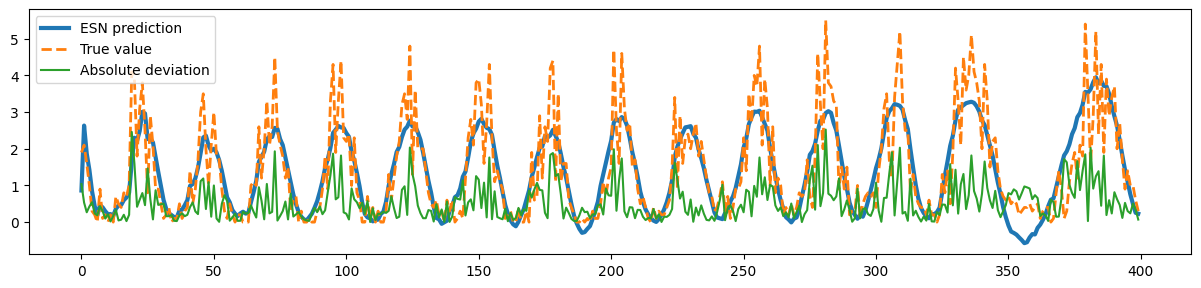

In [24]:
plot_results(outputs_pre, y_train1,400)

With this approach, the systems is better to forecast values thanks to the feedback that allows the continue learning.  

In the group we are amazed and questionning because the reserver is able to forecast even though data is not normalized. We are wondering if this is not thanks of the readout which is marking this approaximations.  

We tried to use normalized data, but this resulted to a not working behavior then bad forecastings. We are willing to work on this for the next days to find why this was not woeking as expected.  